# Initial Imports

In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import scipy.stats as stats

# Preprocessing

In [2]:
raw_SA_df = pd.read_csv("./../../Datasets/kieranFeatures_1-31_21-Jan-2025_avgof3_rawSA.csv")

# Create Low vs High Columns
raw_SA_df["Lv_1_Lo"] = (raw_SA_df["SA1"] < 5).astype(np.bool_)
raw_SA_df["Lv_2_Lo"] = (raw_SA_df["SA2"] < 5).astype(np.bool_)
raw_SA_df["Lv_3_Lo"] = (raw_SA_df["SA3"] < 5).astype(np.bool_)
raw_SA_df["Tot_Lo"] = (raw_SA_df["SAtotal"] < 15).astype(np.bool_)

# Impute missing values with mean of column
for col in raw_SA_df.columns:
    raw_SA_df[col] = raw_SA_df[col].fillna(value = raw_SA_df[col].mean())

# Split up dataset
ids = raw_SA_df["ID"].astype(np.uint8)
outcomes_df = raw_SA_df[["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]]

del col, raw_SA_df

In [3]:
# Load Data
with open("./../../Pickle Files/3_Moving_Average_Raw_SA.pkl", "rb") as f:
    raw_SA_f1_scores, raw_SA_accuracy_scores, raw_SA_CV_models, raw_SA_modified_Ridge_features = pickle.load(f)

with open("./../../Pickle Files/3_Moving_Average_Adj_SA.pkl", "rb") as f:
    adj_SA_f1_scores, adj_SA_accuracy_scores, adj_SA_CV_models, adj_SA_modified_Ridge_features = pickle.load(f)

In [5]:
def graph_folds(model_1_details, model_2_details, outcomes_df, outcome_var, metric, model_names):
    # Intiailize Baselines (don't need always true line?)
    if metric == "F1":
        baseline = (np.mean(outcomes_df[outcome_var])) / (np.mean(outcomes_df[outcome_var]) + 0.5)
        always_true_line = f1_score(outcomes_df[outcome_var], np.array([1 for _ in range(len(outcomes_df[outcome_var]))]))
    elif metric == "Accuracy":
        baseline = 0.5

    fig, axes = plt.subplots(2, 2, sharex = True, sharey = True)
    fig.set_figheight(7.5)
    fig.set_figwidth(7.5)

    for _, (ax, penalty) in enumerate([(axes[0, 0], "No Penalty"), (axes[0, 1], "Ridge") , (axes[1, 0], "LASSO"), (axes[1, 1], "Modified Ridge (L2)")]):
        model_1_dataset_type = model_1_details["Dataset Type"]
        model_2_dataset_type = model_2_details["Dataset Type"]

        model_1_scores = model_1_details["Scores"][model_1_dataset_type][outcome_var][penalty]
        model_2_scores = model_2_details["Scores"][model_2_dataset_type][outcome_var][penalty]

        # Plot Actual vs Shuffled
        for i, (model_1_score, model_2_score) in enumerate(zip(model_1_scores, model_2_scores)):
            ax.plot([0, 1], [model_1_score, model_2_score], marker = "o", label = f"Test Fold {i + 1}")

        # Model 1 Data Boxplot
        ax.boxplot(model_1_scores, vert = True, positions = [-0.1])

        # Shuffled Data Boxplot
        ax.boxplot(model_2_scores, vert = True, positions = [1.1])

        # Baselines
        if metric == "F1":
            ax.axhline(y = always_true_line, color = "r", label = "Always True", linestyle = "--")
        ax.axhline(y = baseline, color = "black", label = "0.5 Line", linestyle = "--")

        # Visual Adjustments
        ax.set_xticks([0, 1], model_names)
        ax.set_xlim([-0.2, 1.2])

        # Labeling Per Graph
        ax.set_title(penalty)
    

    # Labeling
    fig.supxlabel("Model Type")
    fig.supylabel(f"{metric} Score")
    fig.suptitle(f"{metric} Test Fold Scores for {outcome_var} Models")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc = "upper right", bbox_to_anchor = [1.2, 0.9])
    fig.tight_layout()

# Raw SA Actual vs Shuffled

## SA 1

### F1

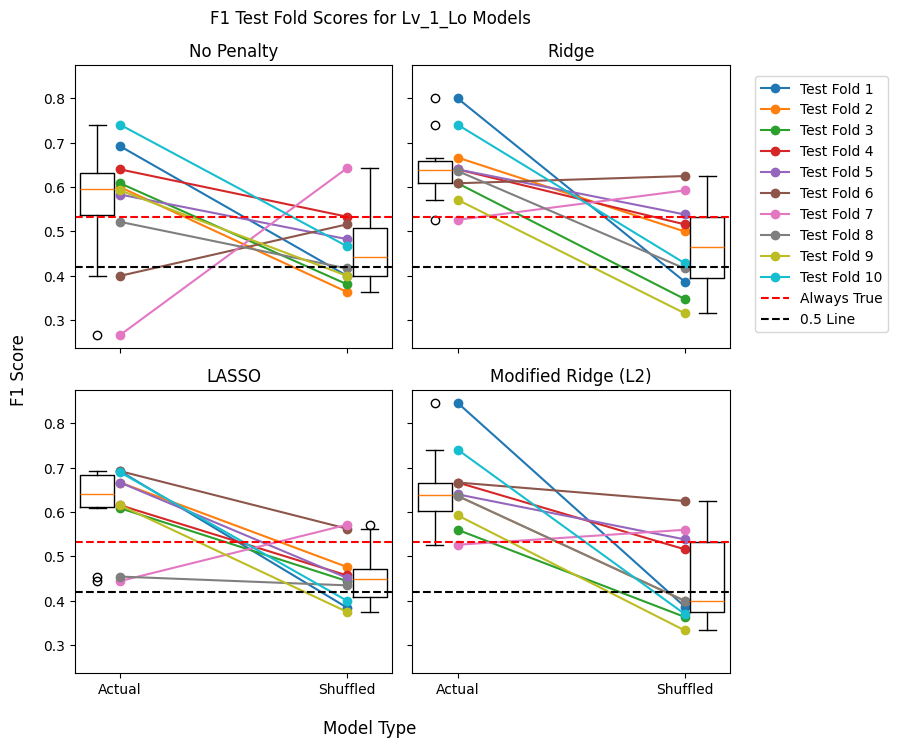

In [6]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": raw_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_1_Lo", 
    metric = "F1", 
    model_names = ["Actual", "Shuffled"]
)

### Accuracy

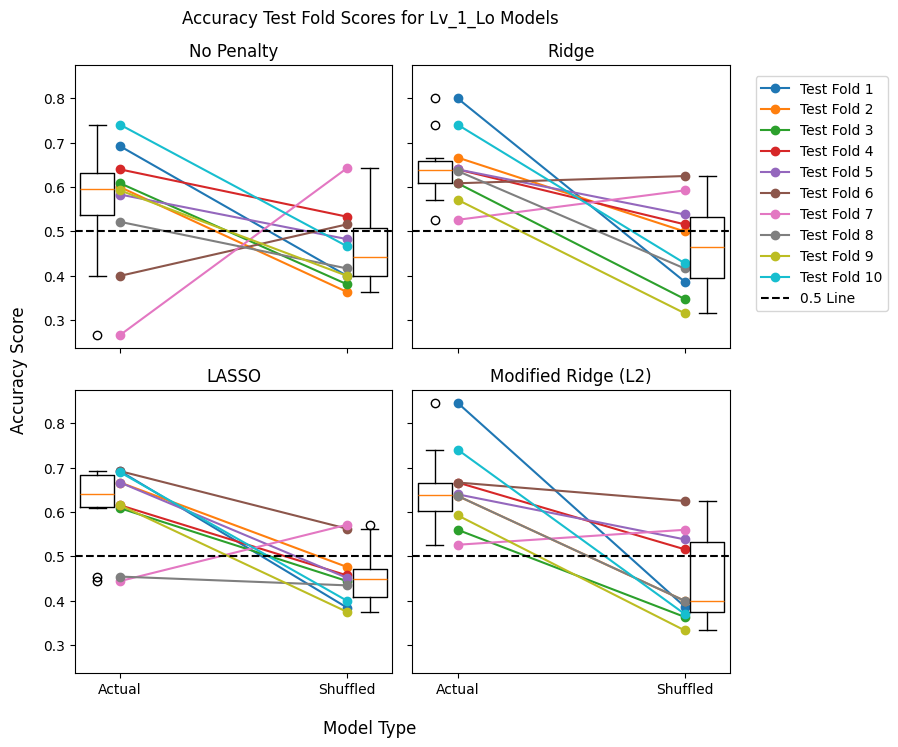

In [7]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": raw_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_1_Lo", 
    metric = "Accuracy", 
    model_names = ["Actual", "Shuffled"]
)

## SA 2

### F1

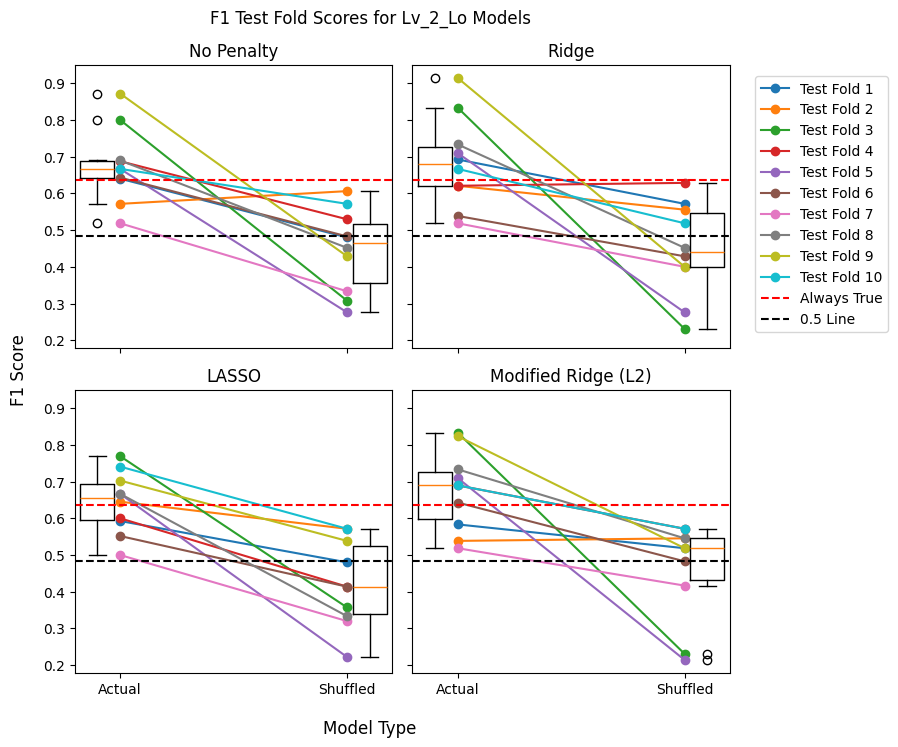

In [8]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": raw_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_2_Lo", 
    metric = "F1", 
    model_names = ["Actual", "Shuffled"]
)

### Accuracy

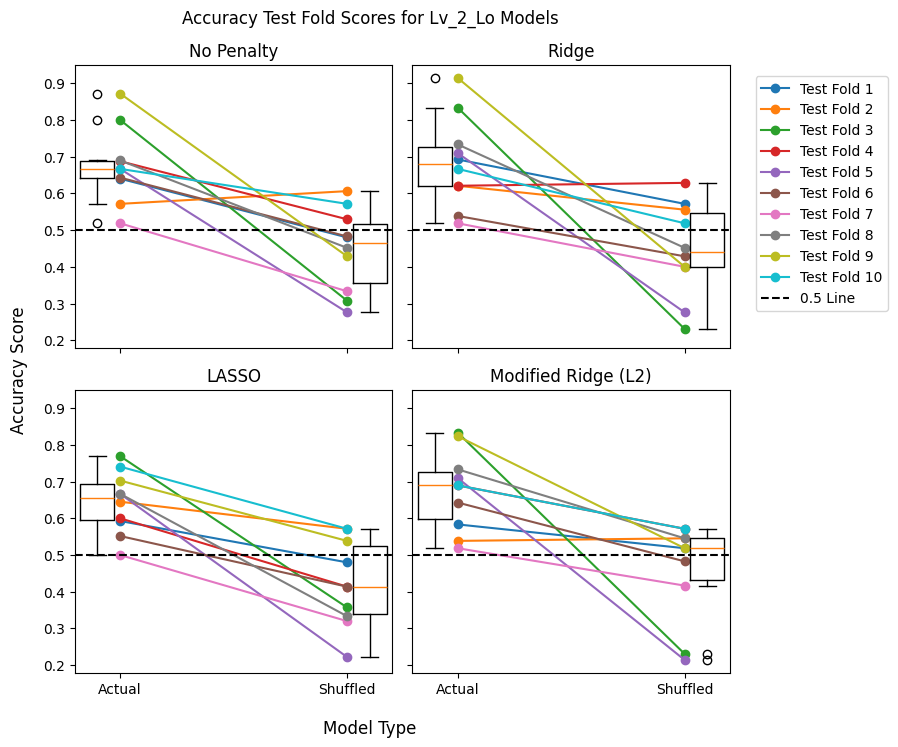

In [9]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": raw_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_2_Lo", 
    metric = "Accuracy", 
    model_names = ["Actual", "Shuffled"]
)

## SA 3

### F1

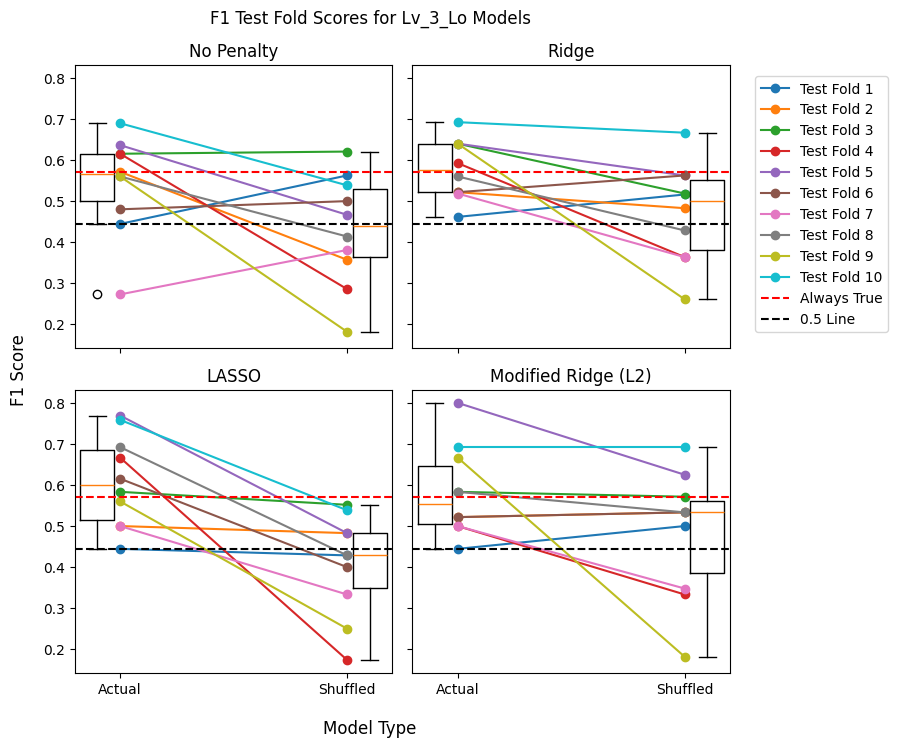

In [10]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": raw_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_3_Lo", 
    metric = "F1", 
    model_names = ["Actual", "Shuffled"]
)

### Accuracy

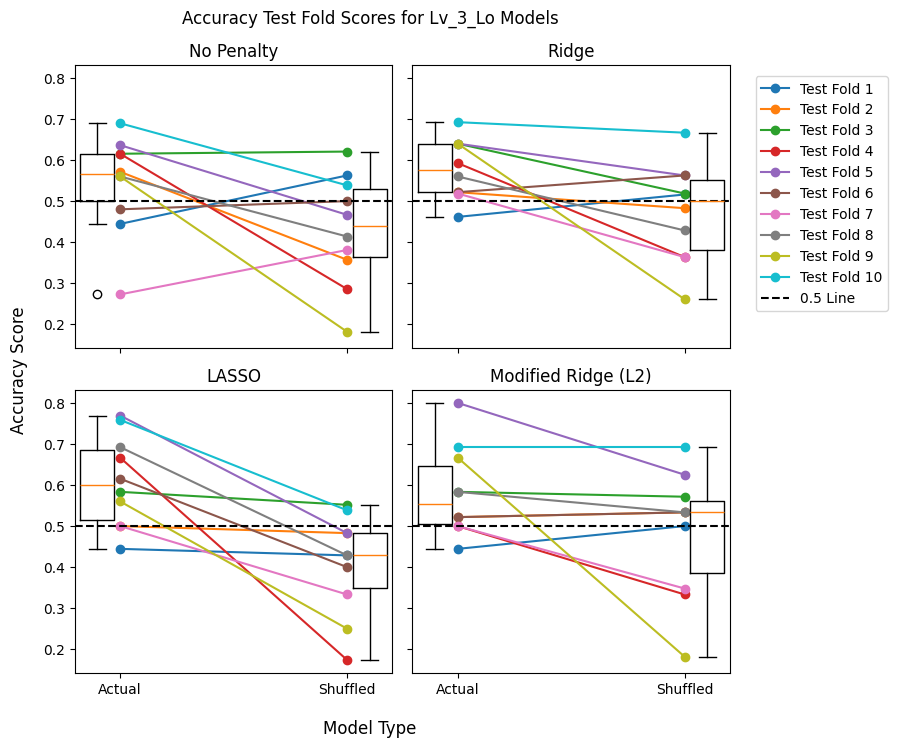

In [11]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": raw_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_3_Lo", 
    metric = "Accuracy", 
    model_names = ["Actual", "Shuffled"]
)

## Total SA

### F1

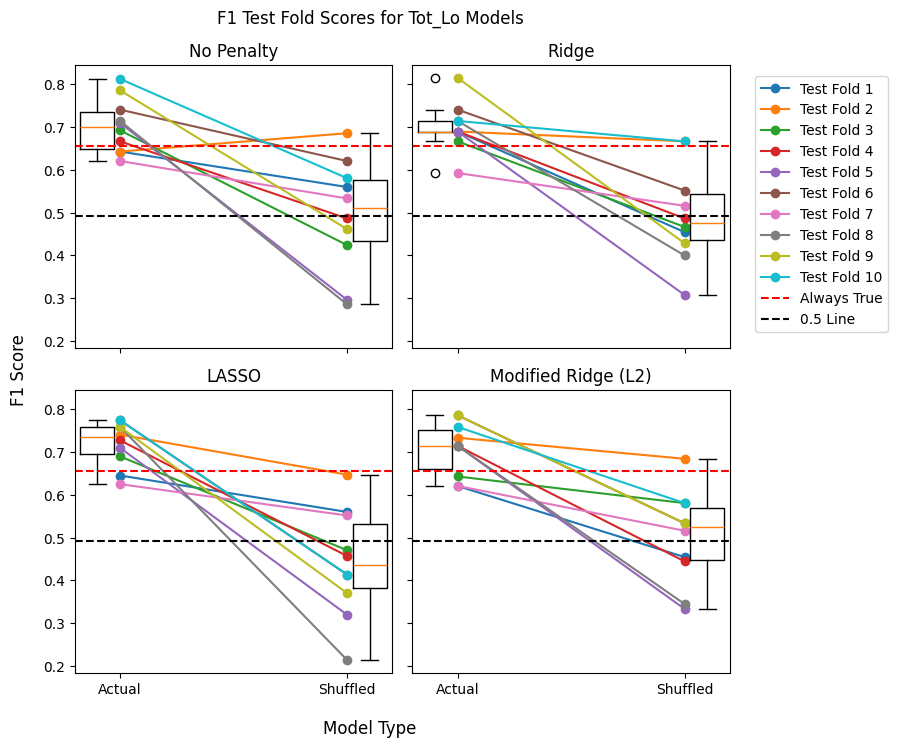

In [12]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": raw_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Tot_Lo", 
    metric = "F1", 
    model_names = ["Actual", "Shuffled"]
)

### Accuracy

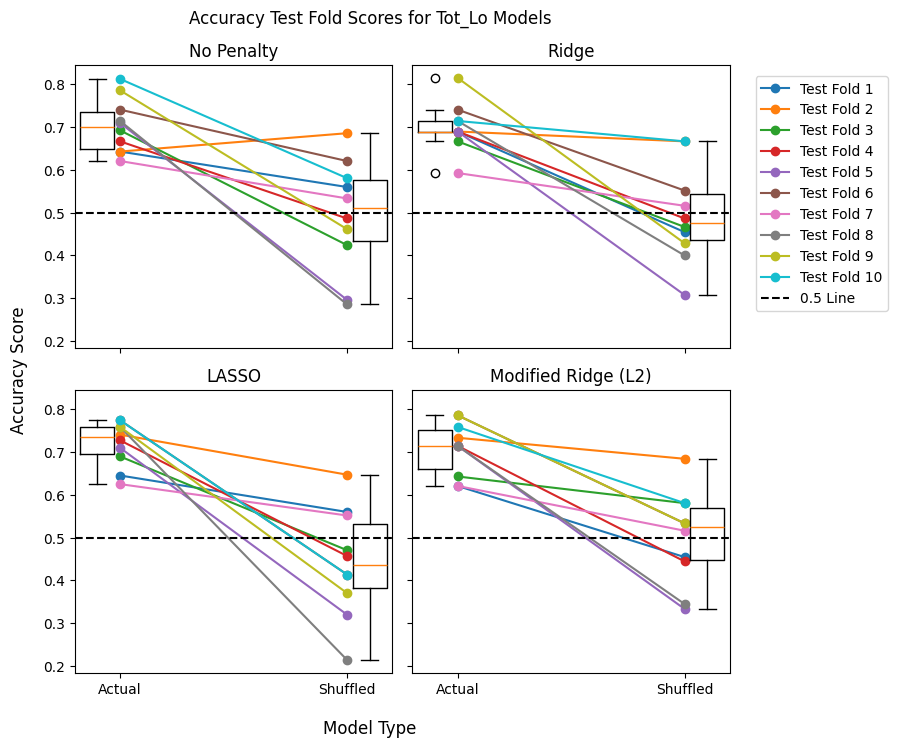

In [13]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Shuffled",
        "Scores": raw_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Tot_Lo", 
    metric = "Accuracy", 
    model_names = ["Actual", "Shuffled"]
)

# Raw vs. Adjusted SA

## SA 1

### F1

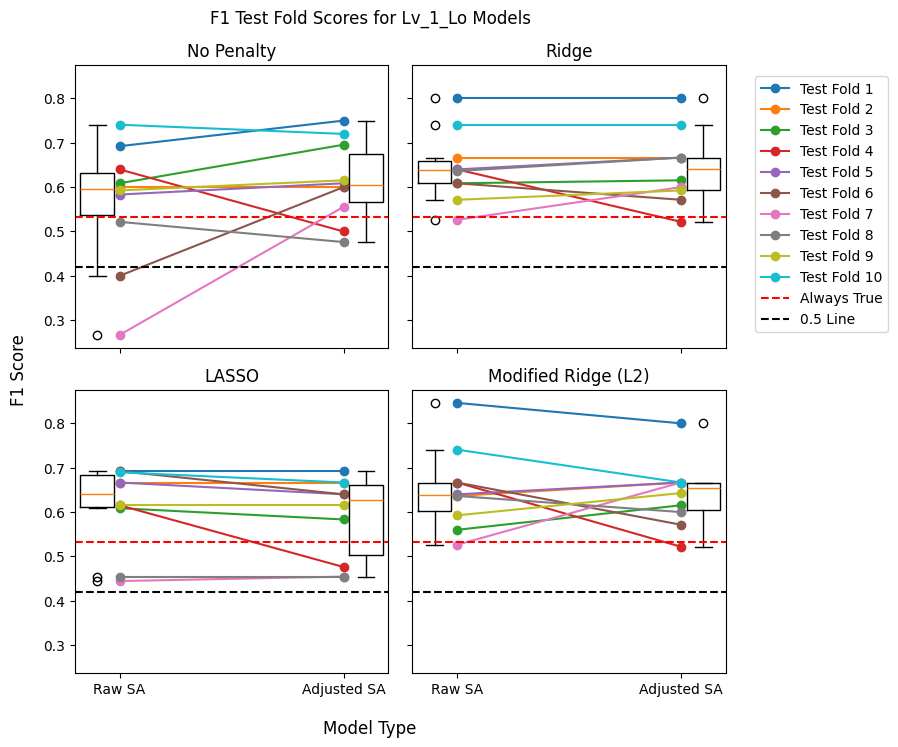

In [ ]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_1_Lo", 
    metric = "F1", 
    model_names = ["Raw SA", "Adjusted SA"]
)

### Accuracy

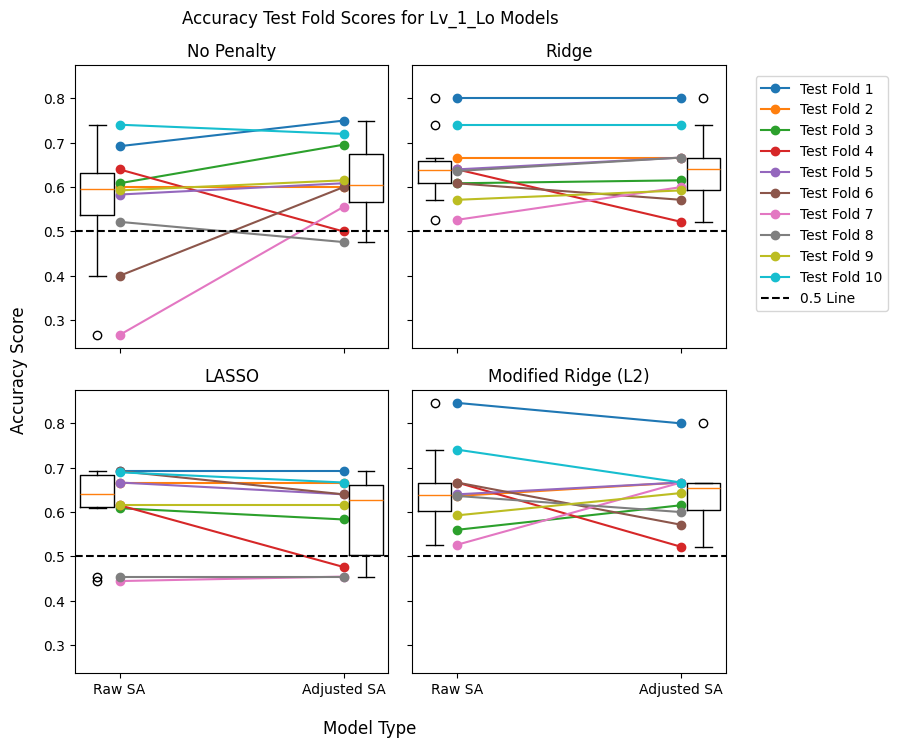

In [14]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_1_Lo", 
    metric = "Accuracy", 
    model_names = ["Raw SA", "Adjusted SA"]
)

## SA 2

### F1

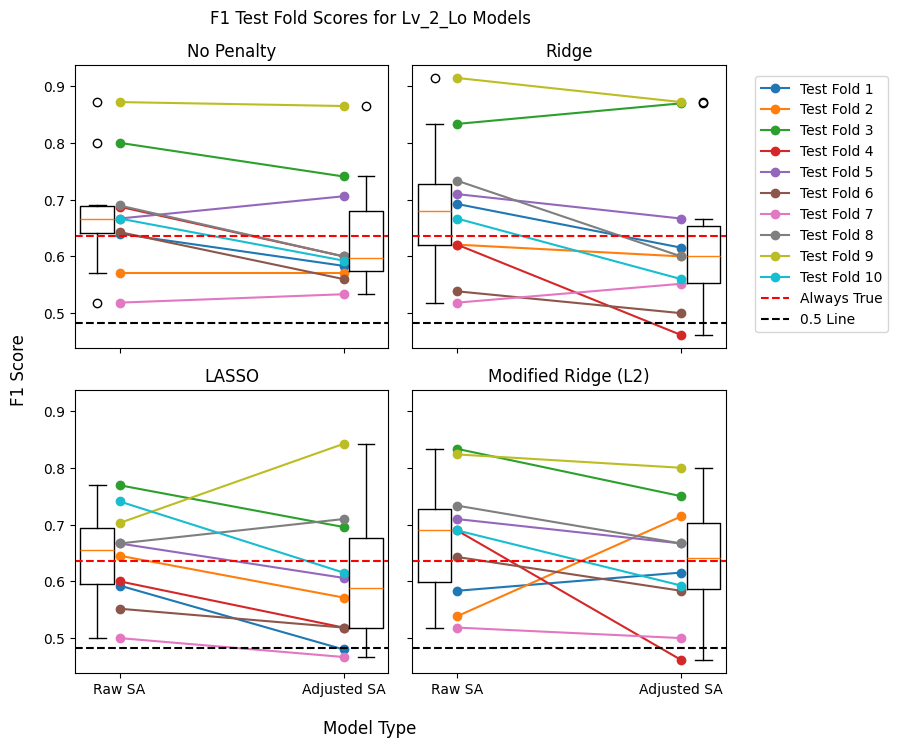

In [6]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_2_Lo", 
    metric = "F1", 
    model_names = ["Raw SA", "Adjusted SA"]
)

### Accuracy

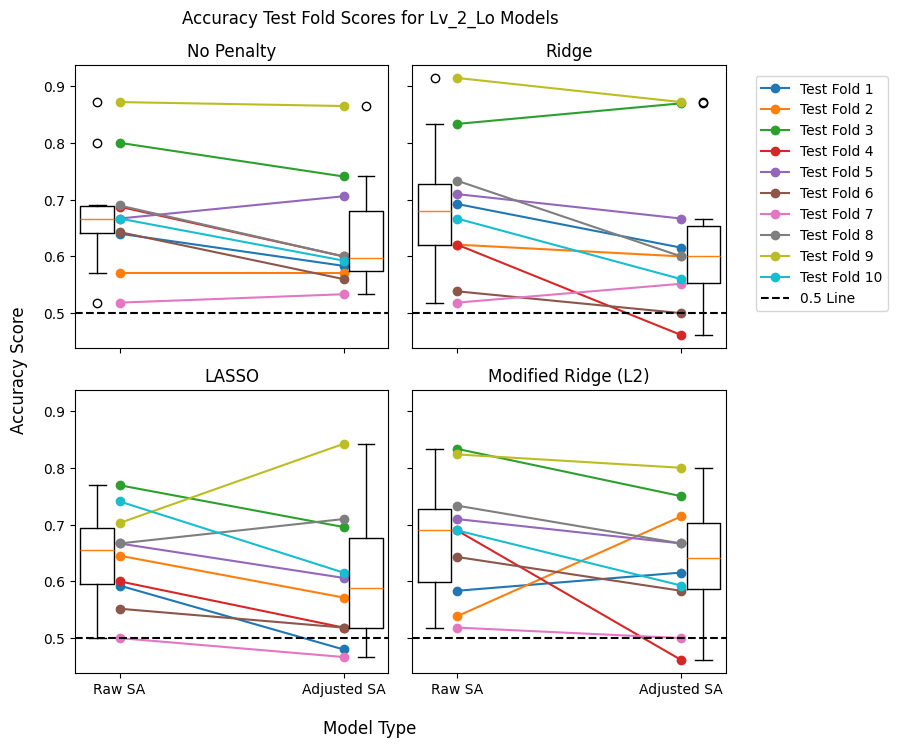

In [15]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_2_Lo", 
    metric = "Accuracy", 
    model_names = ["Raw SA", "Adjusted SA"]
)

## SA 3

### F1

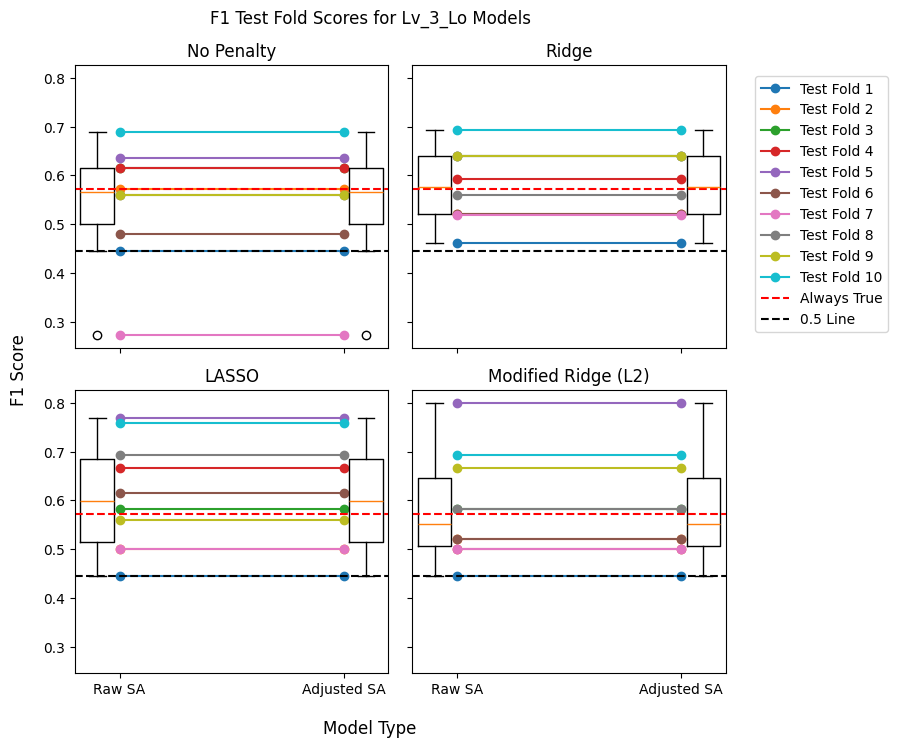

In [7]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_3_Lo", 
    metric = "F1", 
    model_names = ["Raw SA", "Adjusted SA"]
)

### Accuracy

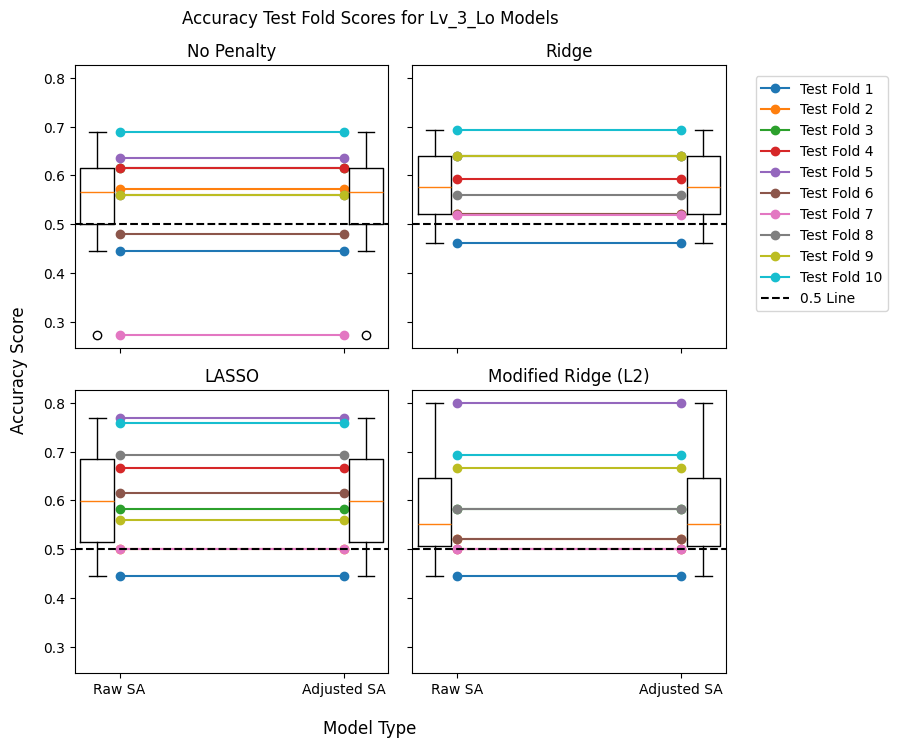

In [16]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Lv_3_Lo", 
    metric = "Accuracy", 
    model_names = ["Raw SA", "Adjusted SA"]
)

## Total SA

### F1

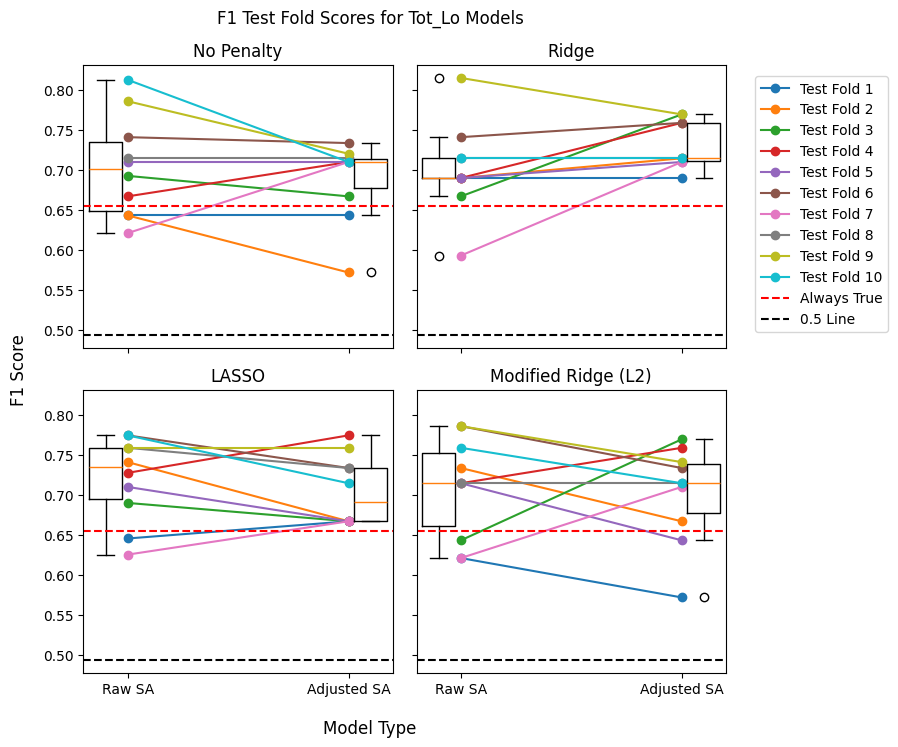

In [5]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Tot_Lo", 
    metric = "F1", 
    model_names = ["Raw SA", "Adjusted SA"]
)

### Accuracy

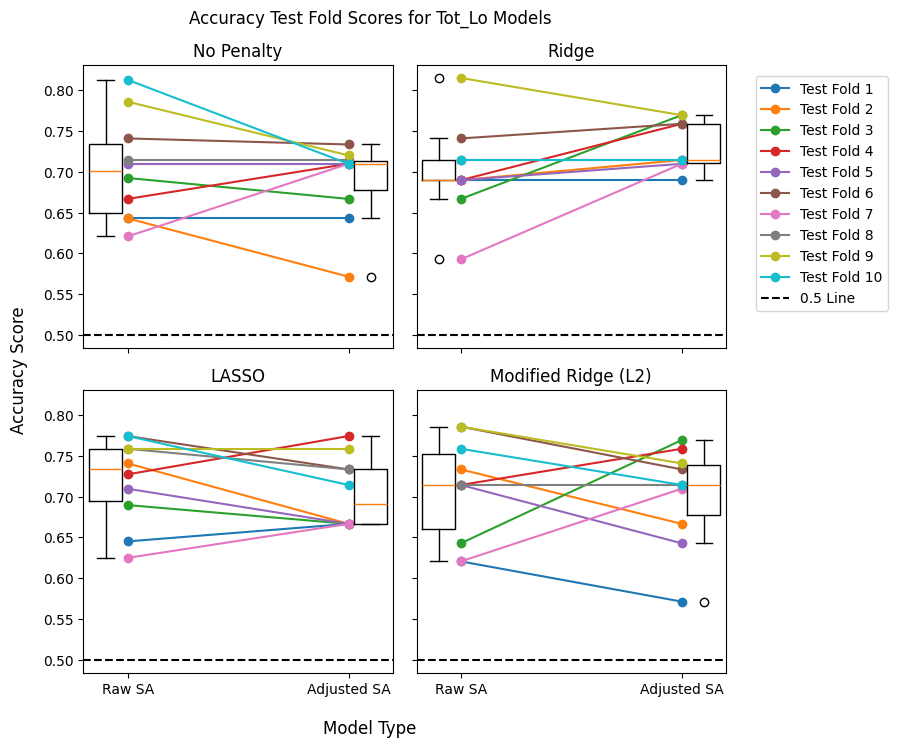

In [17]:
graph_folds(
    model_1_details = {
        "Dataset Type": "Actual",
        "Scores": raw_SA_f1_scores
    },
    model_2_details = {
        "Dataset Type": "Actual",
        "Scores": adj_SA_f1_scores
    }, 
    outcomes_df = outcomes_df, 
    outcome_var = "Tot_Lo", 
    metric = "Accuracy", 
    model_names = ["Raw SA", "Adjusted SA"]
)